In [1]:
from dask_image.imread import imread
import dask.array as da
import os
import numpy as np
import joblib
import dask  # Import Dask first
dask.config.set({'dataframe.query-planning': False})  # Disable query-planning

import dask.dataframe as dd  # Now import dask.dataframe
import pandas as pd
import dask.dataframe as dd
from spatialdata import read_zarr

c:\Users\matti\.conda\envs\ilastik_napari_182\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In [2]:
# sdata = read_zarr(r"C:\Users\Mattias\Documents\projects\HOGENT\Bach_proef\Bachelor_proef_VIB\Testdata_MACSima\Testdata_CA.zarr")
sdata = read_zarr(r"C:\Users\matti\Documents\WERK\STAGE\VIB\data\ilastik_example_data\example_not_multiscaled.zarr")

sdata

c:\Users\matti\.conda\envs\ilastik_napari_182\Lib\site-packages\zarr\creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


SpatialData object, with associated Zarr store: C:\Users\matti\Documents\WERK\STAGE\VIB\data\ilastik_example_data\example_not_multiscaled.zarr
├── Images
│     ├── 'channel_0': DataArray[cyx] (1, 6888, 6888)
│     ├── 'channel_1': DataArray[cyx] (1, 6888, 6888)
│     ├── 'channel_2': DataArray[cyx] (1, 6888, 6888)
│     ├── 'channel_3': DataArray[cyx] (1, 6888, 6888)
│     ├── 'channel_4': DataArray[cyx] (1, 6888, 6888)
│     ├── 'channel_5': DataArray[cyx] (1, 6888, 6888)
│     ├── 'channel_6': DataArray[cyx] (1, 6888, 6888)
│     ├── 'channel_7': DataArray[cyx] (1, 6888, 6888)
│     └── 'channel_8': DataArray[cyx] (1, 6888, 6888)
└── Labels
      └── 'mask': DataArray[yx] (6888, 6888)
with coordinate systems:
    ▸ 'global', with elements:
        channel_0 (Images), channel_1 (Images), channel_2 (Images), channel_3 (Images), channel_4 (Images), channel_5 (Images), channel_6 (Images), channel_7 (Images), channel_8 (Images), mask (Labels)

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

class Feature_extractor(BaseEstimator, TransformerMixin):

    def __init__(self, functions, to_flatten=True):
        super().__init__()
        self.to_flatten = to_flatten
        self.functions = functions

    def fit(self, X, y=None):
        self.max_height = max(img.shape[0] for img in X)
        self.max_width = max(img.shape[1] for img in X)
        return self

    def transform(self, X):
        all_features = []

        for img in X:
            image_features = []

            img = img.astype(np.float32).squeeze()
            img = (img - img.min()) / (img.max() - img.min())
            image_features.append(img)

            h, w = img.shape

            x_coords, y_coords = np.meshgrid(np.arange(w), np.arange(h))
            x_coords = x_coords / self.max_width
            y_coords = y_coords / self.max_height
            image_features.append(x_coords)
            image_features.append(y_coords)

            for f, params in self.functions.items():
                image_features.append(f(img, **params))

            if self.to_flatten:
                image_features = [i.flatten() for i in image_features]
                all_features.append(np.stack(image_features, axis=1))
            else:
                all_features.append(np.stack(image_features))

        return all_features

In [ ]:
from sklearn.pipeline import Pipeline

class Flatten_Pipeline(Pipeline):

    def __init__(self, steps, *, memory = None, verbose = False):
        super().__init__(steps, memory=memory, verbose=verbose)

    def fit(self, X, y = None, **fit_params):
        self.shapes_list = [i.squeeze().shape for i in X]
        return super().fit(X, y, **fit_params)
    
    def predict(self, X, **predict_params):
        flat_preds = super().predict(X, **predict_params)

        # Split flat_preds according to original image sizes
        outputs = []
        idx = 0
        for shape in self.shapes_list:
            count = shape[0]+shape[1]
            slice_preds = flat_preds[idx:idx + count].reshape(shape)
            outputs.append(slice_preds)
            idx += count

        return outputs

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from scipy.ndimage import gaussian_filter, gaussian_gradient_magnitude, gaussian_laplace

pipeline = Flatten_Pipeline([
    ("features", Feature_extractor(functions={
    gaussian_filter: {'sigma':1},
    gaussian_gradient_magnitude: {'sigma':1},
    gaussian_laplace: {'sigma':1},})),
    ("classifier", RandomForestClassifier())
])

data = np.array([i.values.squeeze() for i in sdata.images.values()])
y_all = 

pipeline.fit(data, y_all)             # where y_all = np.concatenate([y.flatten() for y in y])
pred_masks = pipeline.predict(X)

In [5]:
data = np.array([i.values.squeeze() for i in sdata.images.values()])

data.shape

(9, 6888, 6888)

In [6]:
from scipy.ndimage import gaussian_filter, gaussian_gradient_magnitude, gaussian_laplace

data = np.array(list(sdata.images.values())[:5])

trans = Feature_extractor(functions={
    gaussian_filter: {'sigma':1},
    gaussian_gradient_magnitude: {'sigma':1},
    gaussian_laplace: {'sigma':1},
})

transformed = trans.fit_transform(data)

In [46]:
transformed[0][4].shape

(6888, 6888)

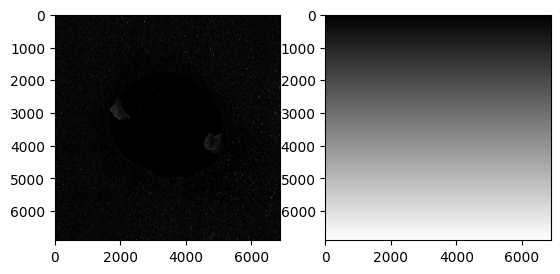

In [55]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.gray()  # show the filtered result in grayscale

ax1 = fig.add_subplot(121)  # left side

ax2 = fig.add_subplot(122)  # right side

index = 1

ax1.imshow(data[index].squeeze())

ax2.imshow(transformed[index][2])

plt.show()